In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
# Create a sample dataframe
df = pd.read_csv('Clean_Data_07-05.csv')


In [2]:
# df

In [3]:
pd.set_option('display.max_columns', None)
# df

In [4]:
import statsmodels.api as sm

# Select all columns except 'Date'
X = sm.add_constant(df.drop(columns=['Date', 'Price', 'Status', 'Build Year', 'URL', 'Adresse', 'Kort adresse', 'Kvdm', 'Latitude', 'Longitude', 
                                     'Kommune', 'Type', 'Price_per_kvdm', 'Price_million', 'Year', 'Natural_log_Price', 'Natural_log_Price_per_kvdm'
                                    , 'Nearest_Metro_Distance', 'Nearest_Tog_Distance', 'Etager']))

# Fit OLS model
model = sm.OLS(df['Natural_log_Price_per_kvdm'], X)
results = model.fit()

# Print the regression summary
# results.summary()


## Residuals

In [5]:
# Fit OLS model
model = sm.OLS(df['Natural_log_Price_per_kvdm'], X)
results = model.fit()

# Get residuals
residuals = results.resid

# Print the first few residuals
# print(residuals.head())

## Pooled OLS

In [6]:
import statsmodels.api as sm
import pandas as pd

# Assuming 'df' is your pre-loaded DataFrame with the correct columns

# Select the columns that will be used as independent variables
# Make sure to include the 'After corona lockdown' dummy variable
X = sm.add_constant(df.drop(columns=['Date', 'Price', 'Status', 'URL', 'Adresse', 'Kort adresse', 'Kvdm', 'Latitude', 'Longitude', 
                                     'Kommune', 'Type', 'Price_per_kvdm', 'Price_million', 'Year', 'Natural_log_Price', 'Natural_log_Price_per_kvdm'
                                    ,'Toiletter', 'Nearest_Metro_Distance', 'Nearest_Tog_Distance', 'Distance_to_rådhus', 'ejendom_alder', 
                                     'KælderAreal', 'Build Year', 'Etager']))

########################################################################################

# denne video er god til at forstå pooled OLS
# https://www.youtube.com/watch?v=CwcNyXDvznE&ab_channel=BenLambert


# List of municipalities and property types
municipalities = [
    'Albertslund', 'Ballerup', 'Brøndby', 'Frederiksberg', 'Furesø',
    'Gentofte', 'Gladsaxe', 'Glostrup', 'Greve', 'Herlev',
    'Hvidovre', 'Ishøj', 'Lyngby-Taarbak', 'Rudersdal', 'Rødovre',
    'Tarnby', 'Vallensbak'
]

# Add interaction terms for each municipality with the 'After corona lockdown' dummy
for mun in municipalities:
    X[f'{mun}_ld_int'] = df[mun] * df['After corona lockdown']
#########################################################################################

# Assume 'df' is your main DataFrame and 'X' is the DataFrame you're preparing for regression or analysis
# 'After corona lockdown' should be a binary variable (0 or 1) already present in df

X['D_metro_1-2_ld_int'] = df['D_metro_1-2'] * df['After corona lockdown']
X['D_metro_2-3_ld_int'] = df['D_metro_2-3'] * df['After corona lockdown']
X['D_metro_3_plus_ld_int'] = df['D_metro_3_plus'] * df['After corona lockdown']

X['D_Tog_1-3_ld_int'] = df['D_Tog_1-3'] * df['After corona lockdown']
X['D_Tog_3-6_ld_int'] = df['D_Tog_3-6'] * df['After corona lockdown']
X['D_Tog_6_plus_ld_int'] = df['D_Tog_6_plus'] * df['After corona lockdown']

X['D_Radhus_1-5_ld_int'] = df['D_Radhus_1-5'] * df['After corona lockdown']
X['D_Radhus_5-10_ld_int'] = df['D_Radhus_5-10'] * df['After corona lockdown']
X['D_Radhus_10_plus_ld_int'] = df['D_Radhus_10_plus'] * df['After corona lockdown']


X['Værelser_ld_int'] = df['Værelser'] * df['After corona lockdown']
X['Toiletter_ld_int'] = df['Toiletter'] * df['After corona lockdown']

# X['Ejerlejlighed_ld_int'] = df['Ejerlejlighed'] * df['After corona lockdown']
X['Villa_ld_int'] = df['Villa'] * df['After corona lockdown']
X['Rækkehus_ld_int'] = df['Rækkehus'] * df['After corona lockdown']


X = sm.add_constant(X)

# Define the dependent variable from the DataFrame
y = df['Natural_log_Price_per_kvdm']

# Fit the OLS model with robust covariance (HC3)
model = sm.OLS(y, X).fit(cov_type='HC3')

# Print the regression summary to output
print(model.summary())


                                OLS Regression Results                                
Dep. Variable:     Natural_log_Price_per_kvdm   R-squared:                       0.536
Model:                                    OLS   Adj. R-squared:                  0.535
Method:                         Least Squares   F-statistic:                     2246.
Date:                        Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                                18:00:17   Log-Likelihood:                -5657.3
No. Observations:                      112204   AIC:                         1.146e+04
Df Residuals:                          112132   BIC:                         1.215e+04
Df Model:                                  71                                         
Covariance Type:                          HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

C:\Users\jtami\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 72, but rank is 71
  warnings.warn('covariance of constraints does not have full '


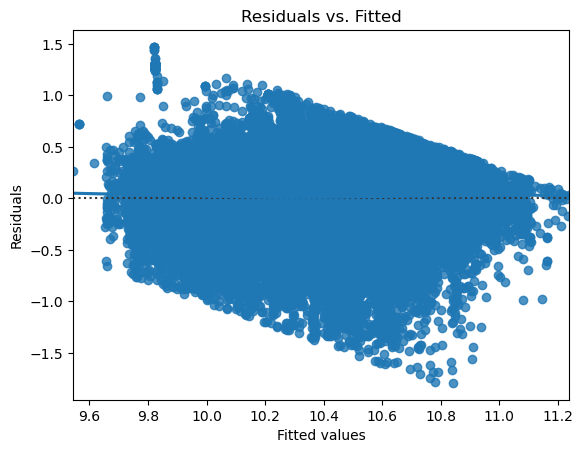

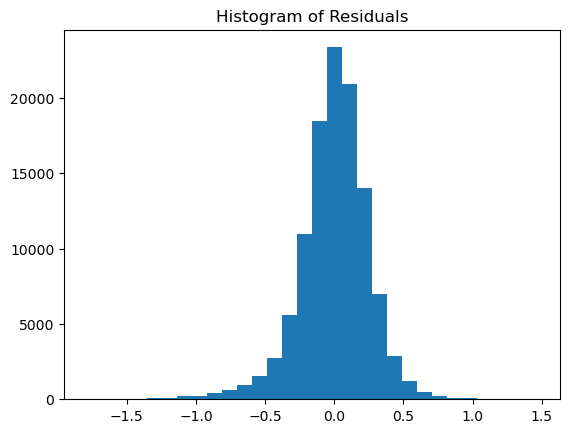

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting residuals
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

# Histogram of residuals
plt.hist(model.resid, bins=30)
plt.title('Histogram of Residuals')
plt.show()


## Refit the Model with Significant Variables Only

In [13]:
# Get the summary table as a DataFrame
results_summary = model.summary2().tables[1]  # Use summary2 for easier DataFrame handling

# Filter out significant variables based on p-value threshold
significant_vars = results_summary[results_summary['P>|z|'] <= 0.05].index.tolist()

# Ensure 'const' is included for the intercept, if it was significant
if 'const' not in significant_vars and 'const' in X.columns:
    significant_vars.insert(0, 'const')

# Subset the original DataFrame X to include only significant variables
X_significant = X[significant_vars]

# Fit the model again with only significant variables
model_filter = sm.OLS(y, X_significant).fit()

# View the summary of the new model
print(model_filter.summary())

                                OLS Regression Results                                
Dep. Variable:     Natural_log_Price_per_kvdm   R-squared:                       0.536
Model:                                    OLS   Adj. R-squared:                  0.535
Method:                         Least Squares   F-statistic:                     2230.
Date:                        Sun, 12 May 2024   Prob (F-statistic):               0.00
Time:                                18:21:08   Log-Likelihood:                -5671.7
No. Observations:                      112204   AIC:                         1.146e+04
Df Residuals:                          112145   BIC:                         1.203e+04
Df Model:                                  58                                         
Covariance Type:                    nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [14]:
import statsmodels.api as sm
from statsmodels.nonparametric.kernel_regression import KernelReg


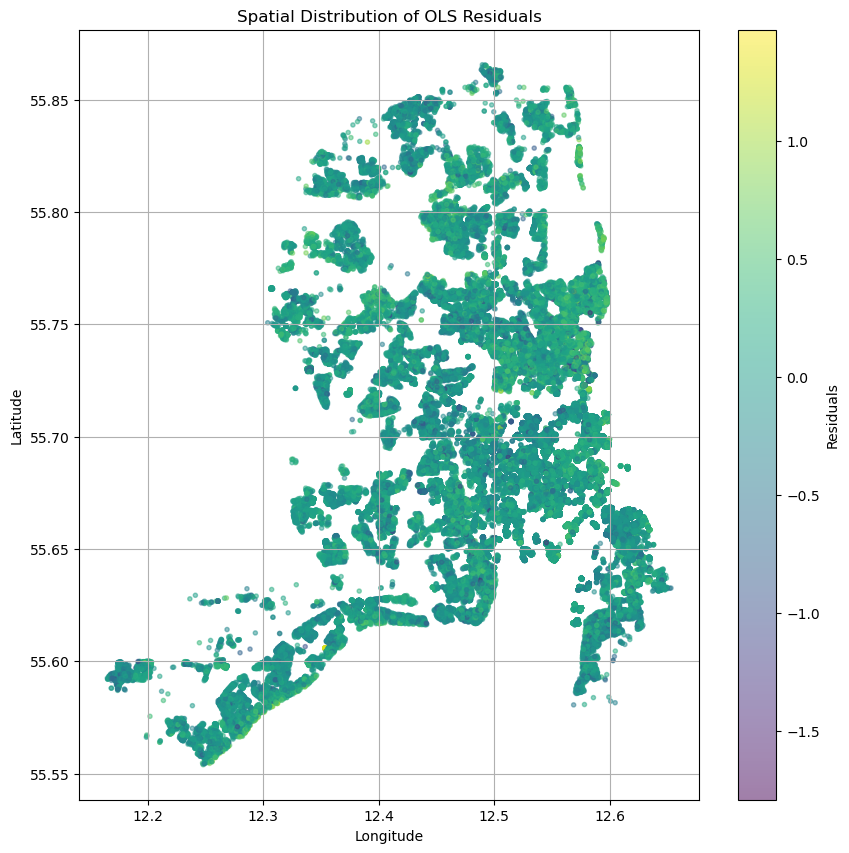

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and model is your fitted OLS model from statsmodels
df['residuals'] = model_filter.resid

# Plot setup
plt.figure(figsize=(10, 10))
plt.scatter(df['Longitude'], df['Latitude'], c=df['residuals'], cmap='viridis', alpha=0.5, marker='.')
plt.colorbar(label='Residuals')
plt.title('Spatial Distribution of OLS Residuals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Binning the data
num_cells_lon = 120
num_cells_lat = 120
lon_bins = np.linspace(df['Longitude'].min(), df['Longitude'].max(), num_cells_lon + 1)
lat_bins = np.linspace(df['Latitude'].min(), df['Latitude'].max(), num_cells_lat + 1)
df['lon_bin'] = np.digitize(df['Longitude'], lon_bins) - 1
df['lat_bin'] = np.digitize(df['Latitude'], lat_bins) - 1
df['lon_bin'] = df['lon_bin'].clip(0, num_cells_lon - 1)
df['lat_bin'] = df['lat_bin'].clip(0, num_cells_lat - 1)

# Aggregating residuals
aggregated_residuals = df.groupby(['lon_bin', 'lat_bin'])['residuals'].mean().reset_index()

# Assuming you set up the NW analysis to use these aggregated residuals
# This part will depend on your specific requirements and setup for the NW analysis


In [16]:
# Calculate the center longitude and latitude for each grid cell
df['lon_center'] = (lon_bins[df['lon_bin']] + lon_bins[df['lon_bin'] + 1]) / 2
df['lat_center'] = (lat_bins[df['lat_bin']] + lat_bins[df['lat_bin'] + 1]) / 2

# Aggregate residuals for each grid cell
aggregated_residuals = df.groupby(['lon_bin', 'lat_bin']).agg({
    'residuals': 'mean',
    'lon_center': 'first',  # No need to average centers as they are constant for the bin
    'lat_center': 'first'
}).reset_index()

# Now use the aggregated_residuals with lon_center and lat_center in the NW regression


In [17]:
aggregated_residuals

,lon_bin,lat_bin,residuals,lon_center,lat_center
0,0,13,-0.020634,12.167011,55.589036
1,0,14,-0.092422,12.167011,55.591632
2,0,15,-0.192025,12.167011,55.594228
3,1,13,-0.059105,12.171078,55.589036
4,1,14,-0.267493,12.171078,55.591632
...,...,...,...,...,...
3728,118,31,-0.035453,12.646976,55.635766
3729,118,32,0.004760,12.646976,55.638362
3730,118,33,0.076175,12.646976,55.640958
3731,119,30,-0.194884,12.651044,55.633170


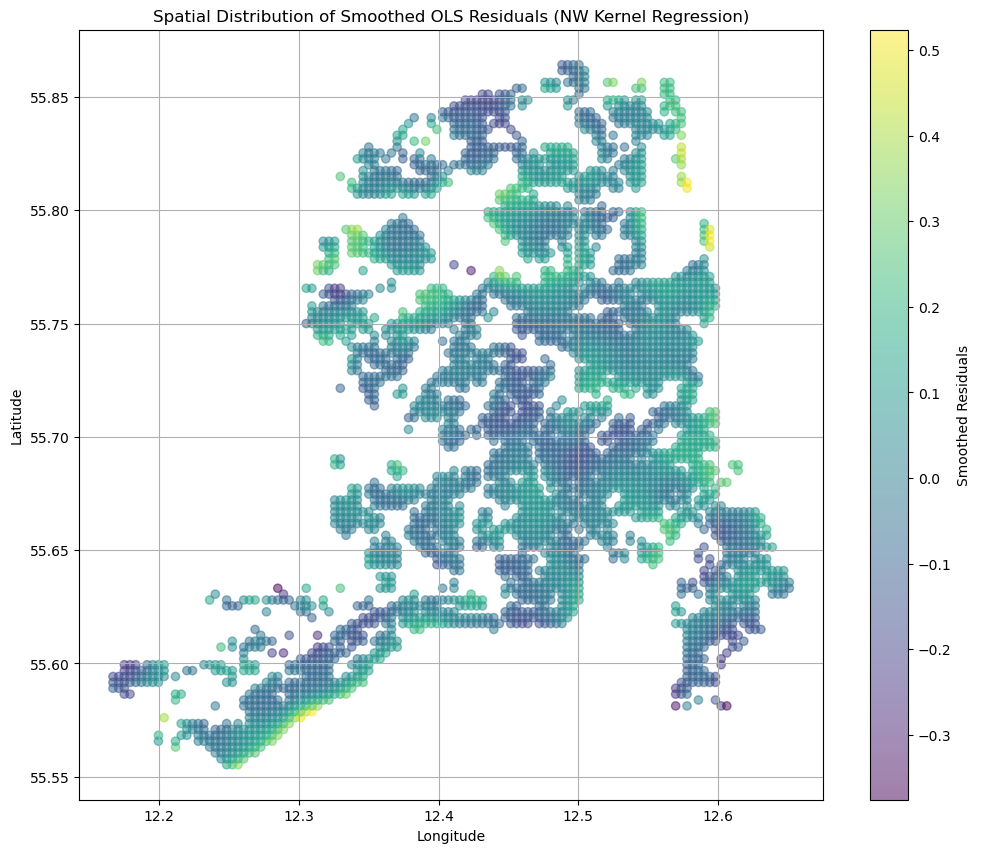

In [18]:
# Ensure statsmodels is updated to the latest version to avoid any compatibility issues.
import statsmodels.api as sm
from statsmodels.nonparametric.kernel_regression import KernelReg

# Prepare the data for the NW analysis, which includes only the non-empty grid cells
X_nw = aggregated_residuals[['lon_center', 'lat_center']]
y_nw = aggregated_residuals['residuals']

# Note that KernelReg expects a 2D array for independent variables (exog)
X_nw = X_nw.values
y_nw = y_nw.values

# Fit the Nadaraya-Watson kernel regression model
# 'll' indicates two continuous variables (longitude and latitude)
# The bandwidth can be specified manually or selected using cross-validation methods
# Here we choose 'cv_ls' for least squares cross-validation
nw_model = KernelReg(endog=y_nw, exog=X_nw, var_type='cc', bw='cv_ls')
nw_fit = nw_model.fit(X_nw)

# Extract the fitted values, which are the smoothed residuals
smoothed_residuals = nw_fit[0]

# Add the smoothed residuals back to the aggregated_residuals DataFrame
aggregated_residuals['smoothed_residuals'] = smoothed_residuals

# Visualizing the smoothed residuals over space
plt.figure(figsize=(12, 10))
sc = plt.scatter(aggregated_residuals['lon_center'], aggregated_residuals['lat_center'], 
                 c=aggregated_residuals['smoothed_residuals'], cmap='viridis', alpha=0.5)
plt.colorbar(sc, label='Smoothed Residuals')
plt.title('Spatial Distribution of Smoothed OLS Residuals (NW Kernel Regression)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


In [19]:
# Create a fine grid for interpolation
num_fine = 300
fine_grid_x, fine_grid_y = np.mgrid[
    aggregated_residuals['lon_center'].min():aggregated_residuals['lon_center'].max():complex(0, num_fine),
    aggregated_residuals['lat_center'].min():aggregated_residuals['lat_center'].max():complex(0, num_fine)
]
fine_grid_points = np.vstack((fine_grid_x.ravel(), fine_grid_y.ravel())).T

# Predict on the fine grid (may take some time)
nw_fitted_values_fine = nw_model.fit(fine_grid_points)[0]


In [20]:
# import matplotlib.pyplot as plt

# # Plot the smoothed residuals over the original data points
# plt.figure(figsize=(12, 10))
# plt.scatter(aggregated_residuals['lon_center'], aggregated_residuals['lat_center'], 
#             c=aggregated_residuals['smoothed_residuals'], cmap='viridis', alpha=0.6)
# plt.colorbar(label='Smoothed Residuals')
# plt.title('Scatter Plot of Smoothed OLS Residuals')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.grid(True)
# plt.show()


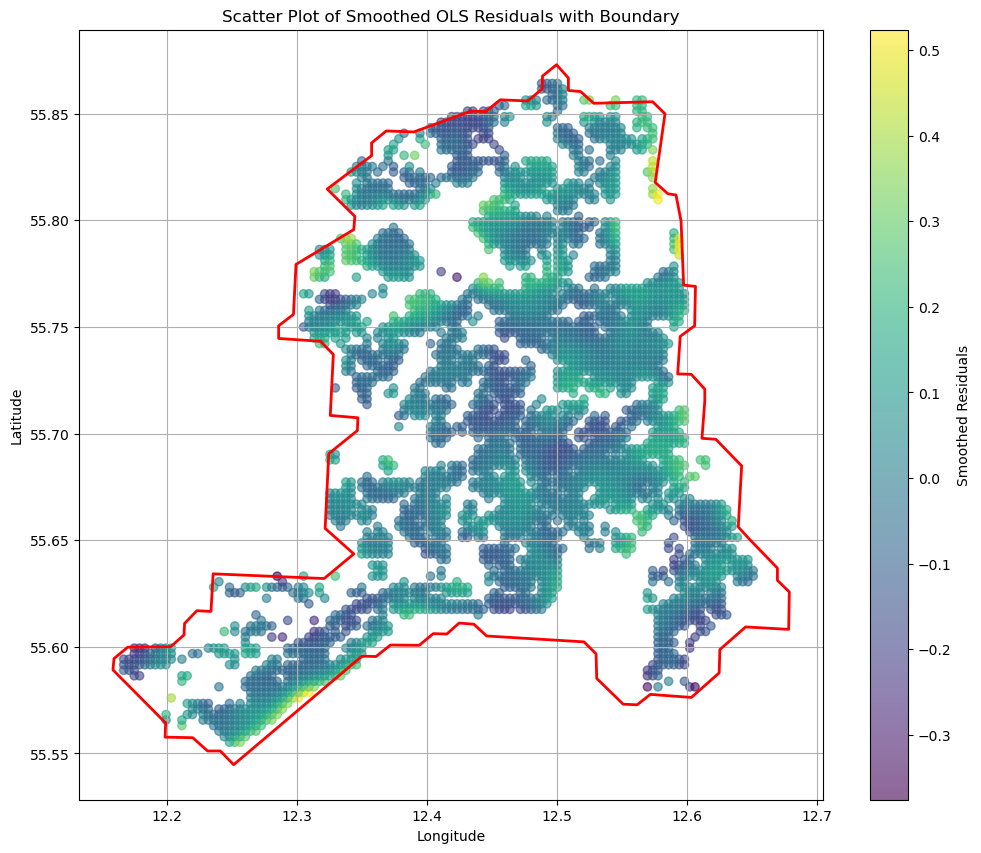

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Given 'aggregated_residuals' and the plot you've already generated with it:

# Plot the smoothed residuals over the original data points
plt.figure(figsize=(12, 10))
plt.scatter(aggregated_residuals['lon_center'], aggregated_residuals['lat_center'], 
            c=aggregated_residuals['smoothed_residuals'], cmap='viridis', alpha=0.6)

# Plot the boundary
boundary_coords = np.array([[12.19925103, 55.56430001],
       [12.15875853, 55.58919064],
       [12.15954479, 55.59452229],
       [12.17015933, 55.59985322],
       [12.20318234, 55.60007533],
       [12.21340375, 55.60562758],
       [12.21379688, 55.610957  ],
       [12.22323203, 55.61695173],
       [12.23412302, 55.6166142 ],
       [12.23575938, 55.63424765],
       [12.32112167, 55.63204551],
       [12.34392327, 55.64358389],
       [12.32190793, 55.65556246],
       [12.32465985, 55.69058982],
       [12.34667519, 55.70144637],
       [12.34706832, 55.70742726],
       [12.32583924, 55.70853473],
       [12.32819803, 55.73709666],
       [12.31836975, 55.74329339],
       [12.286133  , 55.74462113],
       [12.286133  , 55.75059541],
       [12.2975338 , 55.75590511],
       [12.29949946, 55.77934766],
       [12.34392327, 55.79570486],
       [12.34470953, 55.80189228],
       [12.32348046, 55.81470595],
       [12.35762711, 55.83035443],
       [12.35762711, 55.83632493],
       [12.36888367, 55.8419434 ],
       [12.39014608, 55.84147522],
       [12.43401282, 55.85123987],
       [12.4454127 , 55.85105704],
       [12.45648687, 55.85654175],
       [12.47765808, 55.85599331],
       [12.48873225, 55.86166011],
       [12.48905796, 55.8676916 ],
       [12.49980642, 55.87299123],
       [12.50892632, 55.8667778 ],
       [12.50892632, 55.86092896],
       [12.51837194, 55.86038058],
       [12.52846898, 55.85489641],
       [12.57374279, 55.85562768],
       [12.5831884 , 55.84996   ],
       [12.57569705, 55.81776654],
       [12.58546838, 55.81245937],
       [12.59165689, 55.81191032],
       [12.59556542, 55.799646  ],
       [12.59751968, 55.76960958],
       [12.60663959, 55.76905991],
       [12.60598817, 55.75055009],
       [12.594914  , 55.74560043],
       [12.59295973, 55.72799655],
       [12.60338248, 55.72781314],
       [12.61380523, 55.72084271],
       [12.61380523, 55.71533886],
       [12.61162704, 55.69779017],
       [12.62227371, 55.69735422],
       [12.64214207, 55.68487021],
       [12.63953639, 55.65621538],
       [12.64865629, 55.65015108],
       [12.66964429, 55.63693963],
       [12.66964429, 55.63119412],
       [12.6788049 , 55.62573512],
       [12.67829598, 55.60820369],
       [12.64521597, 55.60935353],
       [12.62536796, 55.59871621],
       [12.62485904, 55.58778838],
       [12.60348426, 55.57628212],
       [12.57193102, 55.57772059],
       [12.56175256, 55.57282959],
       [12.55106517, 55.57311731],
       [12.53070824, 55.58519977],
       [12.53019932, 55.59670341],
       [12.52097763, 55.60233897],
       [12.44606412, 55.60509895],
       [12.4362928 , 55.61061832],
       [12.42489292, 55.61117021],
       [12.4154473 , 55.6060189 ],
       [12.40502455, 55.60620288],
       [12.39425978, 55.60073275],
       [12.37211863, 55.6008749 ],
       [12.36104806, 55.59547303],
       [12.35021337, 55.59563296],
       [12.25153747, 55.54473202],
       [12.24131606, 55.55118164],
       [12.23148778, 55.55118164],
       [12.22008698, 55.55740786],
       [12.19883189, 55.55766249],
       [12.19925103, 55.56430001]])

# Add the boundary to the plot. Close the loop by repeating the first point at the end.
boundary_loop = np.vstack([boundary_coords, boundary_coords[0]])
plt.plot(boundary_loop[:, 0], boundary_loop[:, 1], c='red', linewidth=2)

plt.colorbar(label='Smoothed Residuals')
plt.title('Scatter Plot of Smoothed OLS Residuals with Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


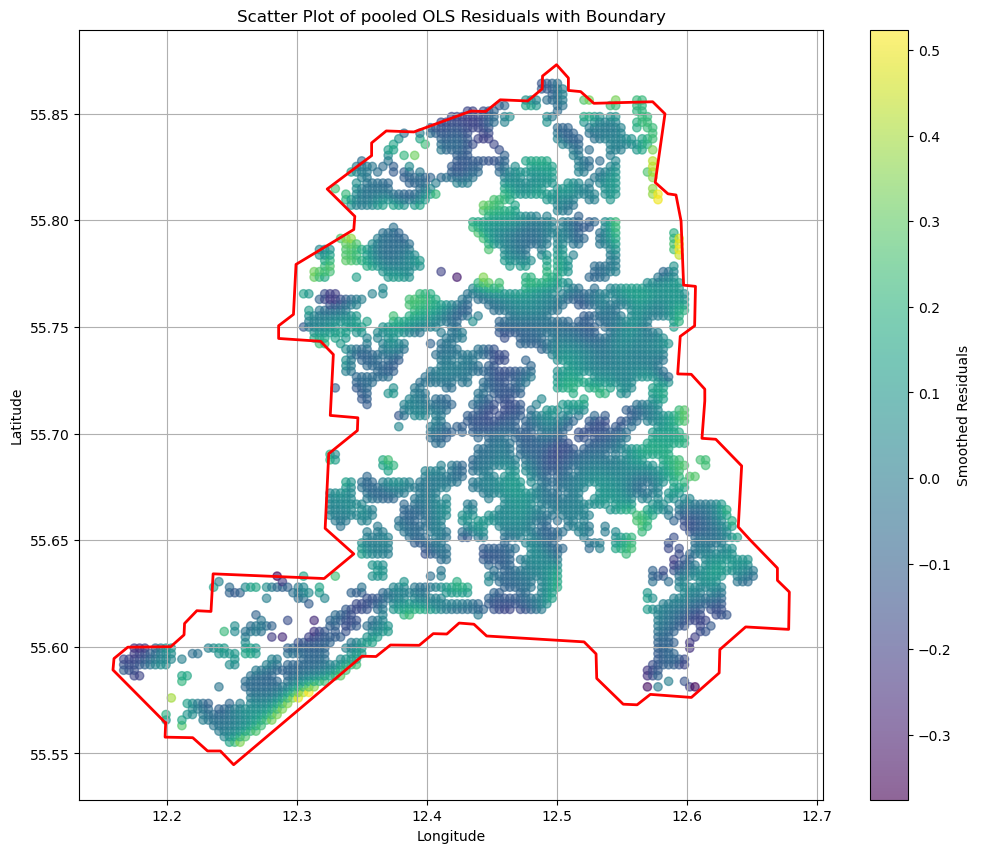

In [27]:
import matplotlib.path as mpath
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'aggregated_residuals' and 'boundary_coords' are defined as shown above

# Create a matplotlib path object from the boundary coordinates
boundary_path = mpath.Path(boundary_coords)

# Create a fine grid for interpolation
num_fine = 300  # Adjust as needed for the density of your data and desired resolution
fine_grid_x, fine_grid_y = np.mgrid[
    aggregated_residuals['lon_center'].min():aggregated_residuals['lon_center'].max():complex(0, num_fine),
    aggregated_residuals['lat_center'].min():aggregated_residuals['lat_center'].max():complex(0, num_fine)
]
fine_grid_points = np.vstack((fine_grid_x.ravel(), fine_grid_y.ravel())).T

# Use the path object to check which grid points are within the boundary
inside_mask = boundary_path.contains_points(fine_grid_points)

# Reshape the mask to match the grid
inside_mask = inside_mask.reshape(fine_grid_x.shape)

# Mask the grid so that only points inside the boundary are True
# When performing the interpolation, we will only interpolate points where inside_mask is True

# Plotting the boundary over the scatter plot
plt.figure(figsize=(12, 10))
plt.scatter(aggregated_residuals['lon_center'], aggregated_residuals['lat_center'], 
            c=aggregated_residuals['smoothed_residuals'], cmap='viridis', alpha=0.6)
plt.plot(boundary_coords[:, 0], boundary_coords[:, 1], c='red', linewidth=2)  # Plot the boundary

# Now you can proceed to interpolate only within this mask.
# If using griddata as previously shown, you would apply the mask after the interpolation is done.

# Your code for interpolation goes here, then apply the inside_mask to the result
# interpolated_data[~inside_mask] = np.nan

plt.colorbar(label='Smoothed Residuals')
plt.title('Scatter Plot of pooled OLS Residuals with Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


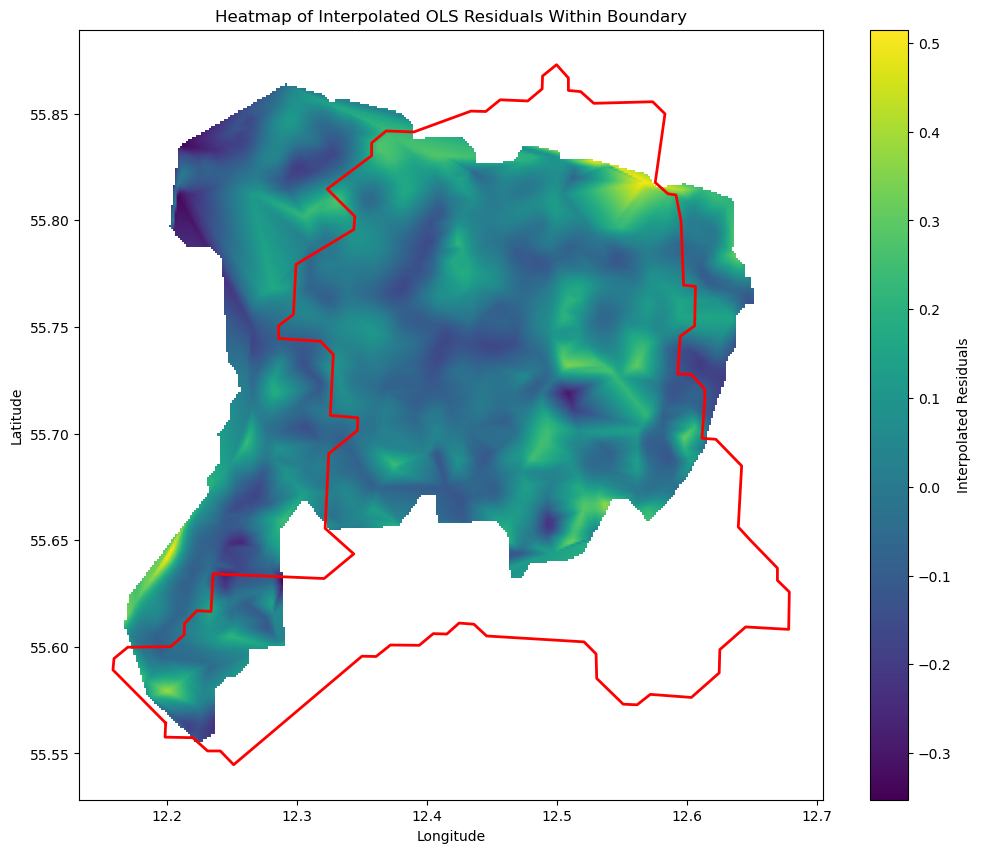

In [23]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath


# Prepare your data points and values for interpolation
lon = aggregated_residuals['lon_center'].values
lat = aggregated_residuals['lat_center'].values
residuals = aggregated_residuals['smoothed_residuals'].values

# Create the fine grid for interpolation
num_fine = 300
fine_grid_x, fine_grid_y = np.mgrid[
    lon.min():lon.max():complex(0, num_fine),
    lat.min():lat.max():complex(0, num_fine)
]

# Create the mask using matplotlib's Path
path = mpath.Path(boundary_coords)
points = np.vstack((fine_grid_x.ravel(), fine_grid_y.ravel())).T
mask = path.contains_points(points)
mask = mask.reshape(fine_grid_x.shape)

# Perform the interpolation
interpolated_values = griddata(
    (lon, lat),
    residuals,
    (fine_grid_x, fine_grid_y),
    method='linear'  # You can also try 'cubic' for smoother results
)

# Apply the mask to the interpolated values
interpolated_values[~mask] = np.nan  # Set points outside the boundary to NaN

# Now plot the results
plt.figure(figsize=(12, 10))
plt.imshow(interpolated_values, origin='lower', aspect='auto', 
           extent=(lon.min(), lon.max(), lat.min(), lat.max()),
           cmap='viridis')
plt.colorbar(label='Interpolated Residuals')
plt.title('Heatmap of Interpolated OLS Residuals Within Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Overlay the boundary
boundary_loop = np.vstack([boundary_coords, boundary_coords[0]])
plt.plot(boundary_loop[:, 0], boundary_loop[:, 1], color='red', linewidth=2)

plt.show()


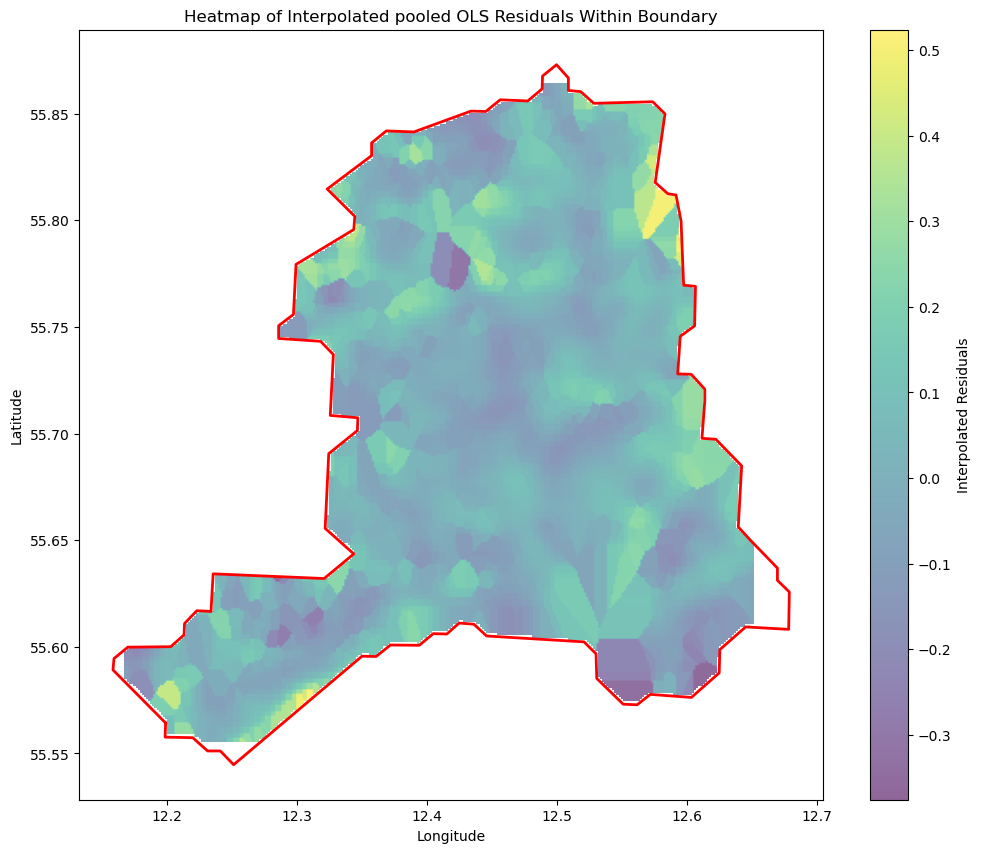

In [25]:
# Perform 'nearest' interpolation
interpolated_nearest = griddata(
    (lon, lat),
    residuals,
    (fine_grid_x, fine_grid_y),
    method='nearest'
)

# Mask out the areas outside the boundary
interpolated_nearest[~inside_mask] = np.nan

# Rotate the interpolated data 90 degrees counterclockwise.
interpolated_nearest_rotated = np.rot90(interpolated_nearest, k=3)  # k=3 rotates 270 degrees counterclockwise
interpolated_nearest_flipped = np.fliplr(interpolated_nearest_rotated)
# Now plot the results with the corrected orientation
plt.figure(figsize=(12, 10))
plt.imshow(interpolated_nearest_flipped, origin='lower', aspect='auto', 
           extent=(lon.min(), lon.max(), lat.min(), lat.max()),
           cmap='viridis', alpha=0.6)
plt.colorbar(label='Interpolated Residuals')
plt.title('Heatmap of Interpolated pooled OLS Residuals Within Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Overlay the boundary with the correct coordinates
plt.plot(boundary_coords[:, 0], boundary_coords[:, 1], color='red', linewidth=2)

plt.show()